In [1]:
import sys
sys.path.append('/Users/demos/PycharmProjects/deloitte_hack/')
#import seaborn as sns 

import dataCrush as dc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from os import listdir
import plotly as pl
from sklearn.ensemble import RandomForestRegressor

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


### explore:
- using NGO_DataDisbursement, we explore the expenditure of the NGO for each policy (x-axis) for all regions. Mean values are depicted 

In [2]:
dc = reload(dc)

regios = ['EMRO', 'EURO', 'CENTRAL AFRICA',
          'SEARO', 'WEST AFRICA', 'PAHO',
          'WPRO', 'SOUTH AFRICA', 'EAST AFRICA']

DF = pd.DataFrame()

for reg in regios:
    df = dc.computeEfectvinessRatioPoliciesPerRegion(Region=reg)
    DF = pd.concat([DF,df], axis=1)

In [3]:
print('-> Top expenditure per desease per region <-')
print('----')
for i in range(len(DF.columns)):
    dis = pd.DataFrame(DF[DF.columns[i]].sort_values(ascending=False)).index[0]
    val = pd.DataFrame(pd.DataFrame(DF[DF.columns[i]].sort_values(ascending=False)).ix[1]).values[0]
    print('(disease -> %s)  --- (Region -> %s) --- (expenditure = %.1f USD Mi.)'%(dis, DF.columns[i], val))

-> Top expenditure per desease per region <-
----
(disease -> Measles-Rubella)  --- (Region -> EMRO) --- (expenditure = 319.0 USD Mi.)
(disease -> Rotavirus)  --- (Region -> EURO) --- (expenditure = 187.2 USD Mi.)
(disease -> Measles)  --- (Region -> CENTRAL AFRICA) --- (expenditure = 164.5 USD Mi.)
(disease -> IPV)  --- (Region -> SEARO) --- (expenditure = 187.7 USD Mi.)
(disease -> Ebola EPI Recovery Plan)  --- (Region -> WEST AFRICA) --- (expenditure = 201.6 USD Mi.)
(disease -> HPV)  --- (Region -> PAHO) --- (expenditure = 148.8 USD Mi.)
(disease -> Measles-Rubella)  --- (Region -> WPRO) --- (expenditure = 227.0 USD Mi.)
(disease -> Measles)  --- (Region -> SOUTH AFRICA) --- (expenditure = 282.0 USD Mi.)
(disease -> HPV)  --- (Region -> EAST AFRICA) --- (expenditure = 255.3 USD Mi.)


### Xplore further and get nice visualization as a funtion of time 

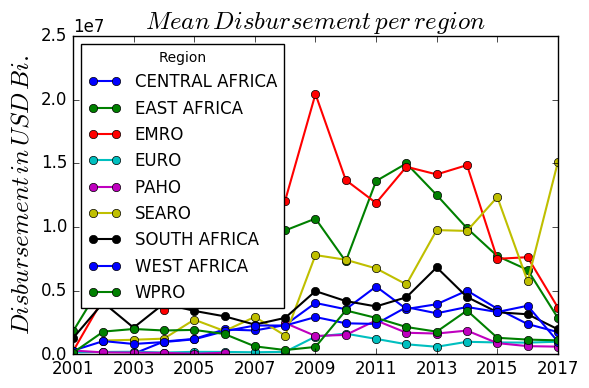

In [4]:
data2 = pd.read_csv('data/'+'NGO_DataDisbursement.csv')

gd = data2.groupby('Region').mean().T
gd = gd.ix[gd.index[1:]]

f, ax = plt.subplots(1,1,figsize=(6,4))
gd.plot(ax=ax, marker='o', linewidth=1.5)
plt.title(r'$Mean\, Disbursement\, per\, region$', fontsize=18)
plt.ylabel('$Disbursement\, in\, USD\, Bi.$', fontsize=18)
plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/cnt.pdf')

# Evolution of expenditure and relationship with coverage

In [5]:
# Select a dataset
val = 'WHO_Coverage_estimates.csv'
data = pd.read_csv('data/'+val)

val2 = 'Death rate, crude (per 1,000 people).xls'
data2 = pd.read_excel('data/'+val2)

def getRankedCountriesForGivenVaccine(data, year='2015', vaccine='DTP3'):
    df = dc.getFeaturesFromVacineTrype(data, vaccine=vaccine)
    return df

## Aggregated and per region mean coverage ratio

In [6]:
# PER REGION
df = getRankedCountriesForGivenVaccine(data, year='2015', vaccine='DTP3')
aggData = df.groupby('Region').mean().T
aggData = aggData.ix[aggData.index[1:-1]][::-1]

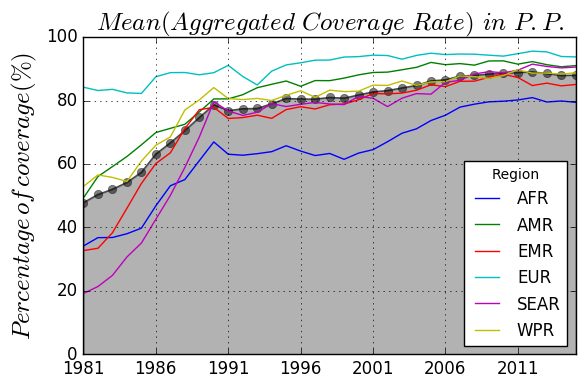

In [7]:
f, ax = plt.subplots(1,1,figsize=(6,4))
df[df.columns[5:-1]].T[::-1].mean(axis=1).plot(kind='area', color='k',
                                              alpha=0.3, ax=ax)
df[df.columns[5:-1]].T[::-1].mean(axis=1).plot(color='k', marker='o', ax=ax,
                                              alpha=0.5)
aggData.plot(ax=ax)
ax.grid(True)
plt.title(r'$Mean(Aggregated$ $Coverage$ $Rate)$ $in$ $P.P.$', fontsize=18)
plt.ylabel('$Percentage\, of\, coverage (\%)$', fontsize=18)
plt.ylim([0,100])
plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/aggCov2.pdf')

## Predicting the coverage gap for 2016 and 2017

In [8]:
x_train = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]['2003':'2015']
x_train = x_train.values
x_test = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]['2015':'2017'].values

In [9]:
labels = aggData['AFR'][gd['WEST AFRICA'].index]['2003':'2015'].values
labels

array([ 69.69565217,  71.08695652,  73.69565217,  75.36956522,
        77.91304348,  78.84782609,  79.58695652,  79.7826087 ,
        80.17021277,  80.91489362,  79.53191489,  79.85106383,  79.42553191])

In [10]:
# PREDICT VALUES USING SKLEARN
model2 = RandomForestRegressor()
model2.fit(x_train, labels)
pred = model2.predict(x_test)

newDf = aggData['AFR'][gd['WEST AFRICA'].index]
newDf['2016'] = pred[0]; newDf['2017']  = pred[1]

### plot

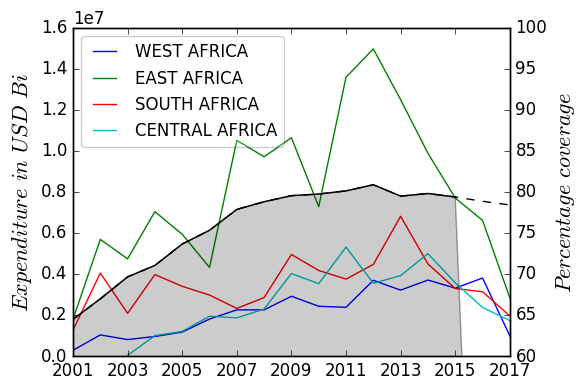

In [11]:
#gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']].plot()
gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']].plot()
plt.legend(fancybox=True, framealpha=0.2, loc='upper left')
plt.ylabel('$Expenditure$ $in$ $USD$ $Bi$', fontsize=16)
ax = plt.twinx()
newDf.plot(linestyle='--', color='k',ax=ax)
newDf['2001':'2015'].plot(linestyle='-', color='k',ax=ax)
aggData['AFR'][gd['WEST AFRICA'].index].plot(kind='area',alpha=0.2,
                                             ax=ax, color='k')
ax.set_ylabel('$Percentage$ $coverage$', fontsize=16)
ax.set_ylim([60,100])
plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/deloitte /prediction.pdf')

# Coverage rate per vacinne 

In [12]:
dc = reload(dc)
R = dc.CoverageRatePerVaccine(year='2014')
R

,AFR,AMR,EMR,EUR,SEAR,WPR
DTP1,87.234043,95.800000,88.952381,96.415094,94.000000,94.185185
DTP3,79.425532,91.000000,85.047619,93.735849,90.545455,88.740741
HepB_BD,79.857143,72.647059,77.800000,93.727273,83.400000,84.318182
HepB3,79.659574,89.428571,84.952381,91.466667,90.545455,88.423077
Hib3,79.425532,90.057143,85.047619,92.096154,85.500000,86.615385
IPV1,33.526316,40.588235,75.785714,87.625000,46.714286,38.428571
Pol3,79.617021,90.800000,85.285714,93.924528,90.636364,89.000000
MCV1,77.404255,92.885714,83.285714,92.603774,88.818182,88.037037
MCV2,64.565217,84.357143,80.900000,91.120000,88.000000,85.000000
PCV3,74.305556,84.291667,84.461538,84.689655,40.500000,75.062500


## OLS

In [13]:
# Select a dataset
val = 'Death rate, crude (per 1,000 people).xls'
data = pd.read_excel('data/'+val)

# Select a dataset
val2 = 'WHO_Coverage_estimates.csv'
dataF = pd.read_csv('data/'+val2)

In [14]:
rg = data[['Country Name','2003']]

In [15]:
rg.sort_values(rg.columns[1],ascending=False).head(10)

,Country Name,2003
207,Sierra Leone,21.166
263,Zimbabwe,19.458
32,Central African Republic,18.999
139,Lesotho,18.591
3,Angola,17.574
226,Chad,17.462
39,Cote d'Ivoire,16.932
172,Nigeria,16.757
166,Malawi,16.532
199,Russian Federation,16.400


In [16]:
africanCountries = dataF[dataF['Region'] == 'AFR'].Cname.values
africanCountries[0:3]

array(['Algeria', 'Angola', 'Benin'], dtype=object)

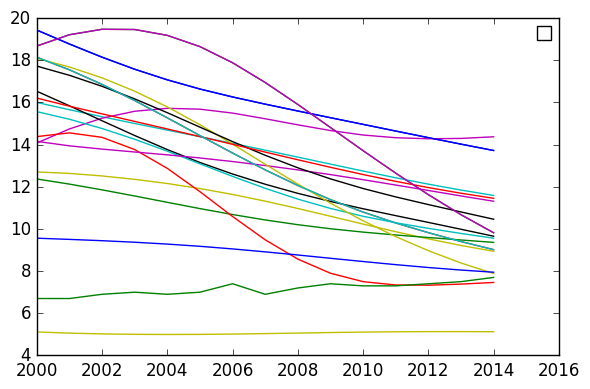

In [17]:
africanCountries = ['Angola','Zimbabwe', 'Zambia',
                   'South Sudan', 'Swaziland', 'Togo', 'Uganda',
                    'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
                   'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique',
                   'United Republic of Tanzania', 'Zambia', 'Zimbabwe', 'Algeria']
#africanCountries = dataF[dataF['Region'] == 'AFR'].Cname.values

DF = pd.DataFrame()
f,ax = plt.subplots(1,1,figsize=(6,4))
for i in range(len(africanCountries)):
    try:
        aggdt = data[data[data.columns[0]] == africanCountries[i]].T
        aggdt['2000':].plot(ax=ax)
        DF = pd.concat([DF, aggdt['2000':]],axis=1)
        plt.legend('')
    except:
        pass
    
DF = DF.mean(axis=1)
plt.tight_layout()

DF1 = DF.copy() 
DF = DF['2003':'2014']

# Predicting the Death ratio for the African continent 

In [18]:
x_train = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]['2003':'2014']
x_train = x_train.values
x_test = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]['2014':'2016'].values

In [19]:
labels = DF['2003':'2015'].values
labels

array([ 14.29995,  13.89555,  13.45255,  12.9937 ,  12.48115,  12.0214 ,
        11.58335,  11.16755,  10.79795,  10.4676 ,  10.16545,   9.8965 ])

In [20]:
# PREDICT VALUES USING SKLEARN
model2 = RandomForestRegressor(max_depth=300)
model2.fit(x_train, labels)
pred = model2.predict(x_test)

DF = pd.DataFrame(DF)

In [21]:
pred

array([ 10.527045,  11.09202 ,  11.875935])

In [22]:
DF1['2015'] = pred[0]
DF1['2016'] = pred[1]
DF1['2017'] = pred[2]

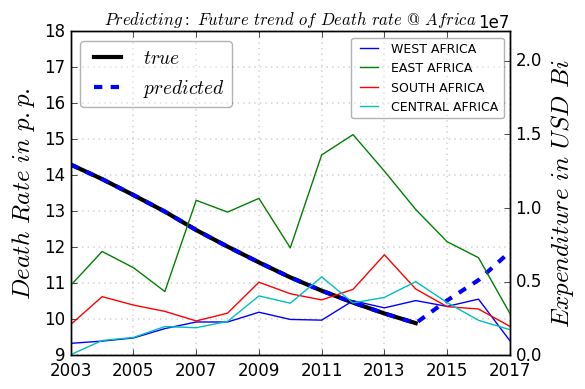

In [23]:
ttt = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]

DF.plot(linewidth=3, color='k')
DF1[DF.index[0]:'2017'].plot(linestyle='--', color='b',
                      linewidth=3)
plt.ylabel(r'$Death$ $Rate$ $in$ $p.p.$', fontsize=18)
plt.legend([r'$true$',r'$predicted$'], fontsize=14,
           loc='upper left', fancybox=True,
          framealpha=.3)
plt.ylim([9,18])
plt.grid(linewidth=.2)
a = plt.twinx()
ttt[DF[:'2017'].index[0]:].plot(ax=a)
a.legend(loc='upper right', fancybox=True, fontsize=9,
          framealpha=.3)
a.set_ylabel(r'$Expenditure$ $in$ $USD$ $Bi$', fontsize=18)
a.set_title(r'$Predicting:$ $Future$ $trend$ $of$ $Death$ $rate$ $@$ $Africa$')
a.set_ylim([0.0*1e7,2.2*1e7])
plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/deloitte /deatRatePrediction2.pdf')